# Trabajo Práctico N°2 
Asignatura: Minería de Datos.

Carrera: Tecnicatura Universitaria en Inteligencia Artificial.

Año: 2024.

Integrantes:
- López Ceratto, Julieta: L - 3311/1.
- Rodríguez Griñó, Tomás: R - 4643/4

# Librerías.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer


# Funciones a utilizar.

In [2]:
def plot_multiple_conf_matrices(y_real_list, y_pred_list, titles):      
    num_matrices = len(y_real_list)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    # Lista de colormaps para seleccionar aleatoriamente
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'coolwarm', 'cividis', 'magma']
    for i in range(num_matrices):
        color = random.choice(colormaps)
        cm = confusion_matrix(y_real_list[i], y_pred_list[i])
        sns.heatmap(cm, annot=True, ax=axes[i], fmt='d', cmap=color)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')

    # Oculta cualquier eje restante si hay menos de 4 matrices
    for j in range(num_matrices, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [34]:
def pd_metricas_clasifier(dict_modelos:dict, m_type: str = 'clasifier', m: str = None, cv: bool = False, cv_folds: int = 5, model = None, x_list : list = []):
    metricas_modelos = pd.DataFrame()    
    for key,value in dict_modelos.items():
        valores_modelo = value[0]
        if m == 'SVM':
            metrica_clas = {
            'Nombre_Modelo': key,
            'C' : valores_modelo[0],
            }
        elif m == 'RandomForest':
            metrica_clas = {
            'Nombre_Modelo': key,
            'n_estimators' : valores_modelo[0],
            'criterio': valores_modelo[1],
            'max_deph': valores_modelo[2],
            'min_samples_split': valores_modelo[3],
            'min_samples_leaf': valores_modelo[4],
            'max_features': valores_modelo[5]
            }
        else:
            metrica_clas = {
                'Nombre_Modelo': key
            }
        
        if m_type == 'clasifier':
            if cv:
                # Definir estrategia de validación cruzada
                cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

                # Definir las métricas
                scoring = {
                    'precision': make_scorer(precision_score, average='weighted'),
                    'recall': make_scorer(recall_score, average='weighted'),
                    'accuracy': make_scorer(accuracy_score),
                    'f1': make_scorer(f1_score, average='weighted')
                }

                for i in range(1,len(value)):
                    y_real,y_pred = value[i]
                    X = x_list[i]
                    # Realizar validación cruzada
                    cv_results = cross_validate(model, X, y_real, cv=cv_strategy, scoring=scoring)
                    # Guardar las métricas promedio en el diccionario
                    metrica_clas['Precision Test'] = cv_results['test_precision'].mean()
                    metrica_clas['Recall Test'] = cv_results['test_recall'].mean()
                    metrica_clas['Accuracy Test'] = cv_results['test_accuracy'].mean()
                    metrica_clas['F1-Score Test'] = cv_results['test_f1'].mean()    

            else:
                for i in range(1,len(value)):
                    y_real,y_pred = value[i]
                    metrica_clas[f'Precision Test {i}'] = precision_score(y_real,y_pred, pos_label=0, average='weighted'),
                    metrica_clas[f'Recall Test {i}'] = recall_score(y_real,y_pred, pos_label=0, average='weighted')
                    metrica_clas[f'Accuracy Test {i}'] = accuracy_score(y_real,y_pred),
                    metrica_clas[f'F1-Score Test {i}'] = f1_score(y_real,y_pred, pos_label=0, average='weighted')
        elif m_type == 'regressor':
            for i in range(1,len(value)):
                y_real,y_pred = value[i]
                metrica_clas[f'MAE Test {i}'] = mean_absolute_error(y_real,y_pred),
                metrica_clas[f'MSE Test {i}'] = mean_squared_error(y_real,y_pred)
                metrica_clas[f'RMSE Test {i}'] = np.sqrt(mean_squared_error(y_real,y_pred)),
        metricas_modelos = pd.concat([metricas_modelos,pd.DataFrame(metrica_clas)])
    
    return metricas_modelos

# Carga de datos

In [4]:
clima = pd.read_csv('data\dxWeather.csv')

# Análisis dataset.

Primero analizamos si hay datos faltantes en los 2 datasets

In [5]:
clima

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno
...,...,...,...,...,...,...,...,...
10085,31,24,8.0,5,1029.61,Llanura,Soleado,Verano
10086,29,62,13.0,17,1002.81,Costa,Nublado,Primavera
10087,10,74,14.5,71,1003.15,Montania,Lluvioso,Verano
10088,30,77,5.5,28,1012.69,Costa,Nublado,Otonio


In [6]:
clima.isna().any().any()

False

Revisamos los tipos de datos que poseemos

In [7]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


Luego, vemos y analizamos las distribuciones de los datos numericos del dataset

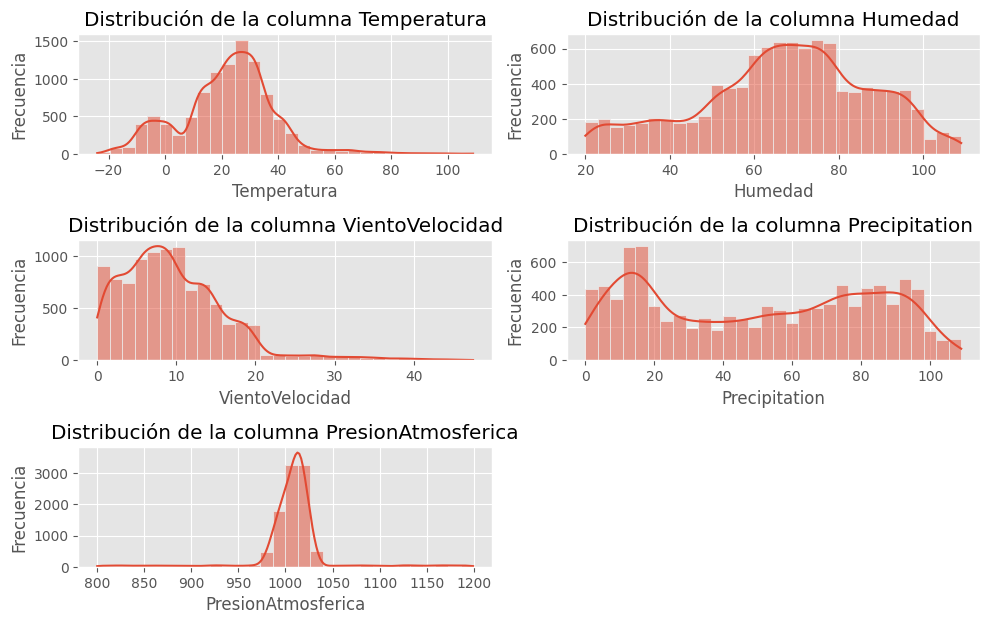

In [8]:
numerical_cols = clima.select_dtypes(include=['float64', 'int64']).columns


n_cols = 2  
n_rows = 5 

plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)  # Crear subgráfica
    sns.histplot(clima[col], bins=30, kde=True)
    plt.title(f"Distribución de la columna {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")


plt.tight_layout()  
plt.show()

### 1. Temperatura
* La distribución de la temperatura parece estar centrada entre aproximadamente 0 y 20 grados, con una ligera asimetría hacia la izquierda (valores negativos).
* La curva KDE (estimación de densidad de núcleo) sugiere que la mayoría de los valores se encuentran entre 0 y 30 grados, con algunos valores extremos hacia el lado negativo, indicando temperaturas bajas, pero estos son menos frecuentes.
* Podría haber valores extremos en la cola izquierda, lo que indica posibles eventos de frío extremo.
### 2. Humedad
* La distribución de la humedad es más bien uniforme, sin un pico muy definido.
* Se observa que la mayor parte de los valores se concentran entre el 60% y el 100%, con algunas fluctuaciones, pero en general, se observa una tendencia de alta humedad.
* Este tipo de distribución puede ser normal en regiones donde la humedad tiende a ser alta durante la mayor parte del tiempo, y sería interesante ver si esto varía estacionalmente.
### 3. Viento Velocidad
* La distribución de la velocidad del viento es asimétrica hacia la derecha, con un pico alrededor de 10 unidades.
* Esto sugiere que la mayoría de las observaciones registran velocidades bajas a moderadas del viento, mientras que las velocidades más altas (más de 30) son poco frecuentes.
* Esta distribución puede indicar que es un área con vientos principalmente moderados, aunque también se presentan algunos eventos de viento fuerte.
### 4. Precipitación
* La precipitación muestra una distribución bastante dispersa, con varios picos.
* La mayoría de los valores están alrededor de 0-20 y luego se extienden con más picos entre 40 y 80, lo que indica una variabilidad en la cantidad de precipitación.
* Esto puede reflejar días con poca lluvia combinados con eventos de lluvias intensas ocasionales. Una inspección adicional por estacionalidad o clima específico podría ayudar a entender mejor esta variabilidad.
### 5. Presión Atmosférica
* La presión atmosférica presenta una distribución muy concentrada alrededor de los 1000 hPa, con una ligera variación.
* Esto es típico, ya que la presión atmosférica no suele fluctuar mucho en condiciones normales, pero pequeñas desviaciones pueden indicar eventos meteorológicos específicos.
* La forma de campana (similar a una distribución normal) sugiere que no hay muchos valores atípicos y que la presión tiende a mantenerse bastante estable en este rango.

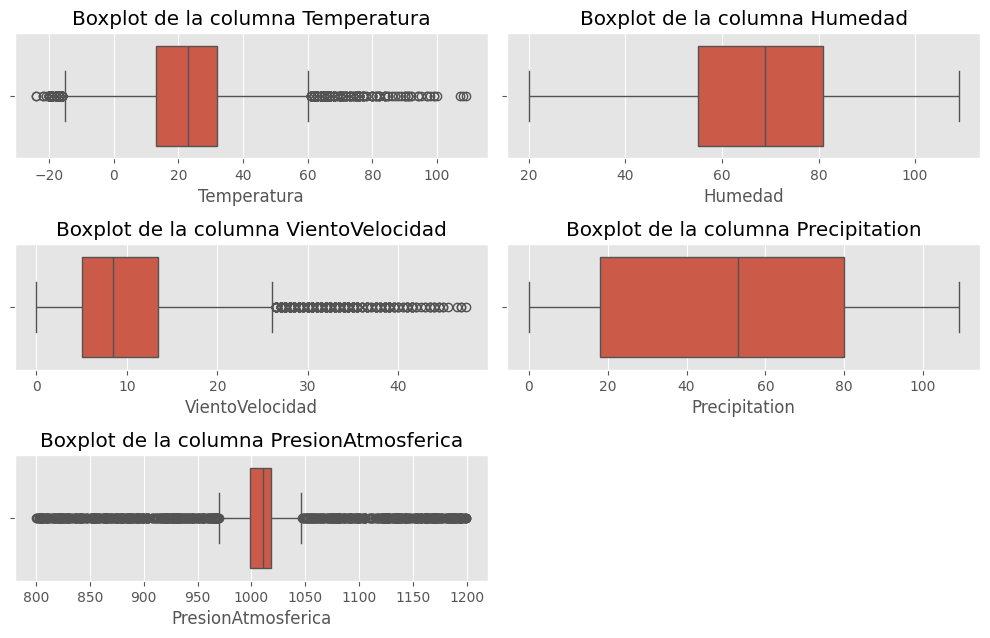

In [9]:
numerical_cols = clima.select_dtypes(include=['float64', 'int64']).columns


n_cols = 2  
n_rows = 5 

plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1 + n_cols)  # Crear boxplot en la siguiente subgráfica
    sns.boxplot(data=clima, x=col)
    plt.title(f"Boxplot de la columna {col}")
    plt.xlabel(col)


plt.tight_layout()  
plt.show()

### 1. Temperatura
* El boxplot muestra que la mayor parte de los valores de temperatura se encuentra entre 0 y 30 grados, lo que coincide con la concentración observada en el histograma anterior.
* Existen varios valores atípicos en el rango superior, alcanzando valores superiores a 80 grados, que parecen ser inusuales y posiblemente anomalías en los datos o eventos extremos.
* También hay valores atípicos en el extremo inferior, con algunas temperaturas menores a -20 grados.
### 2. Humedad
* La humedad tiene una distribución más equilibrada, sin valores atípicos evidentes en los extremos.
* La mayoría de los datos están concentrados entre 60% y 100%, lo cual indica una humedad generalmente alta en los registros.
* La mediana está cerca de 80%, lo que significa que en la mayoría de los casos, los valores de humedad son elevados.
### 3. Viento Velocidad
* La velocidad del viento presenta valores atípicos en el rango superior, con varias observaciones por encima de 20 unidades.
* La mayoría de los valores se concentran por debajo de 15, lo cual indica que los vientos fuertes son poco frecuentes en comparación con vientos de menor velocidad.
* Los outliers en la parte superior sugieren la presencia de algunos eventos de viento muy fuerte, que pueden ser raros o extremos.
### 4. Precipitación
* El boxplot de precipitación muestra una gran dispersión de los datos, sin valores atípicos visibles, lo que indica una variabilidad natural en las cantidades de precipitación.
* La mediana se encuentra cerca del centro del rango, y los datos están distribuidos entre 0 y aproximadamente 100, lo cual refleja tanto días sin lluvia como eventos de precipitación intensa.
* Esta variabilidad sugiere que el dataset cubre tanto eventos de lluvia ligera como fuertes precipitaciones.
### 5. Presión Atmosférica
* La presión atmosférica tiene un rango muy estrecho, con una gran cantidad de valores atípicos en ambos extremos.
* La mayoría de los datos se encuentran alrededor de los 1000 hPa, lo cual es típico para la presión atmosférica en condiciones normales.
* Los outliers en ambos extremos reflejan pequeñas desviaciones de la presión atmosférica estándar, que pueden estar asociadas con cambios meteorológicos o variaciones locales.

# División y preparación Train, Val, Test

In [10]:
X = clima.drop('Estacion', axis = 1)

In [11]:
y = clima['Estacion']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size= 0.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [13]:
(X_train.shape, X_val.shape, X_test.shape)

((6457, 7), (1615, 7), (2018, 7))

In [14]:
## Como son solo 3 los tipos de localización podemos realizar codificación onehot sin que se aumente mucho en dimensionalidad
X_train['Localizacion'].value_counts().unique

<bound method Series.unique of Localizacion
Montania    2273
Llanura     2265
Costa       1919
Name: count, dtype: int64>

In [15]:
## Como son solo 4 los tipos de localización podemos realizar codificación onehot sin que se aumente mucho en dimensionalidad
X_train['TipoClima'].value_counts().unique

<bound method Series.unique of TipoClima
Soleado     1854
Nublado     1789
Lluvioso    1777
Nevado      1037
Name: count, dtype: int64>

In [16]:
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Punto 1: Kernel Lineal.

Realizar la predicción del atributo Estación utilizando máquinas de vectores con kernel lineal analizando el parámetro costo. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

## SVM C mediana

In [17]:
svc_model = make_pipeline(StandardScaler(), SVC(C = 0.05, kernel = 'linear', random_state=100))
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.05, kernel='linear', random_state=100))])

In [18]:
y_predict_svc_model = svc_model.predict(X_train)
y_val_predict_svc_model = svc_model.predict(X_val)
y_test_predict_svc_model = svc_model.predict(X_test)

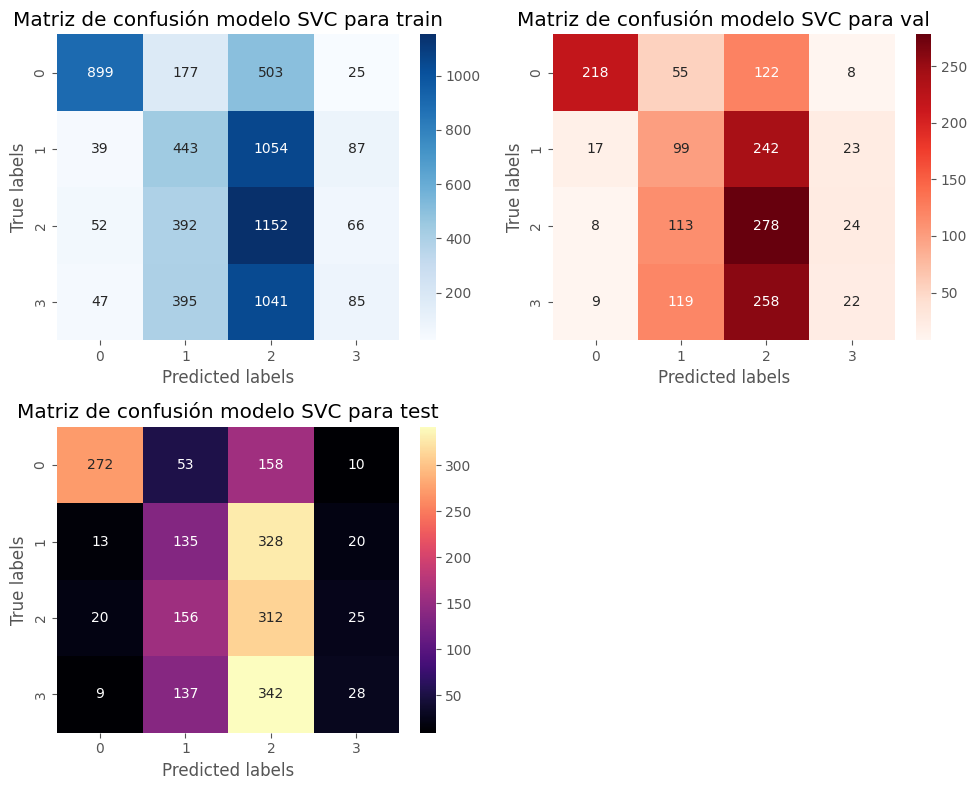

In [19]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model,y_val_predict_svc_model,y_test_predict_svc_model],
    ['Matriz de confusión modelo SVC para train', 'Matriz de confusión modelo SVC para val', 'Matriz de confusión modelo SVC para test']
    )

Podemos ver, que las etiquetas se distribuyen de la siguiente forma para las 3 matrices:
- 0: Invierno (se cuenta por fila 1604, 503, 493 predicciones respectivamente)
- 1: Otonio.
- 2: Primavera.
- 3: Verano.

La primera matriz (datos Train):
 - Para la clase 0 (invierno): de los 1604 datos, solo predice bien 899, es decir un poco más del 50% por lo que se asemeja a un rendiiento cara-cruz aleatorio.
 - Para la etiqueta 1 (Otoño): de los 1623 datos, predice bien sólo 443, por lo que es un rendimiento bajo.
 - Para la etiqueta 2 (Primavera); de los 1662 datos, predice bien 1152 lo cual es muy bueno.
 - Para la etiqueta 3 (Verano): de los 1568 datos, predice bien sólo 85, siendo esta la etiqueta con un rendimiento más bajo.
 Se ve una tendencia general a predecir la etiqueta 2 (es decir, a la estación Primavera)

Con las otras dos matrices (validación y test) se ve cómo se replica esta performance.

Esto se pude deber a que la C es muy baja, es decir tiene una rigurización que no es suficiente para separar bien los datos y hacer predicciones más uniformes entre las clases.

In [20]:
pd.DataFrame(y_train).value_counts().unique, pd.DataFrame(y_val).value_counts().unique , pd.DataFrame(y_test).value_counts().unique

(<bound method Series.unique of Primavera    1662
 Otonio       1623
 Invierno     1604
 Verano       1568
 Name: count, dtype: int64>,
 <bound method Series.unique of Primavera    423
 Verano       408
 Invierno     403
 Otonio       381
 Name: count, dtype: int64>,
 <bound method Series.unique of Verano       516
 Primavera    513
 Otonio       496
 Invierno     493
 Name: count, dtype: int64>)

In [21]:
metricas_svc = pd_metricas_clasifier(
    {'SVC 1': [
        [0.05],
        (y_train,y_predict_svc_model),
        (y_val, y_val_predict_svc_model),
        (y_test,y_test_predict_svc_model)]},
    m_type= 'clasifier',
    m = 'SVM'
)

In [22]:
metricas_svc

,Nombre_Modelo,C,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,SVC 1,0.05,0.45205,0.399411,0.399411,0.374743,0.429459,0.382043,0.382043,0.359996,0.436442,0.370168,0.370168,0.352478


## Cambiando parámetro C

### C menor

In [23]:
svc_model_2 = make_pipeline(StandardScaler(), SVC(C = 0.001, kernel = 'linear', random_state=70))
svc_model_2.fit(X_train, y_train)
y_predict_svc_model_2 = svc_model_2.predict(X_train)
y_val_predict_svc_model_2 = svc_model_2.predict(X_val)
y_test_predict_svc_model_2 = svc_model_2.predict(X_test)

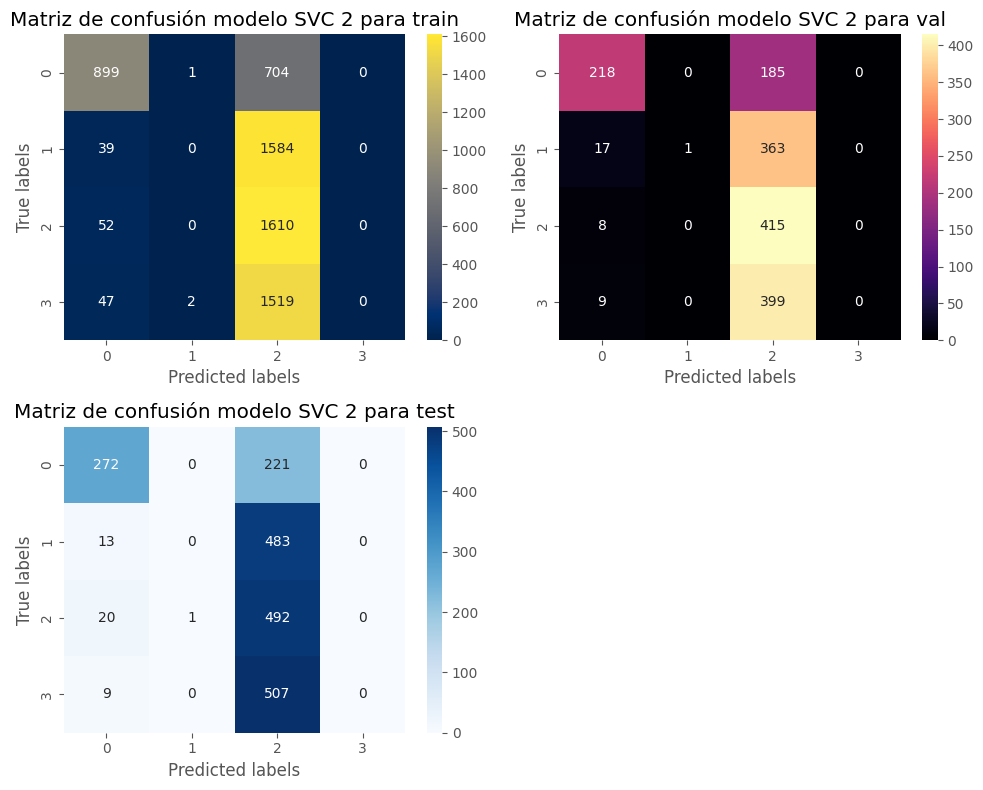

In [24]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model_2,y_val_predict_svc_model_2,y_test_predict_svc_model_2],
    ['Matriz de confusión modelo SVC 2 para train', 'Matriz de confusión modelo SVC 2 para val', 'Matriz de confusión modelo SVC 2 para test']
    )

Con un valor de C menor, la rigurización es menor y se ve cómo tiene a clasificar hacia la clase mayoritaria, algo casi similar en cuanto a performance con lo que pasaría en un Bayes.

In [25]:
metricas_svc = pd.concat(
[metricas_svc,
 pd_metricas_clasifier(
     {'SVC 2': [
         [0.001],
         (y_train,y_predict_svc_model_2),
         (y_val, y_val_predict_svc_model_2),
         (y_test,y_test_predict_svc_model_2)
         ]
    }, m_type= 'clasifier', m = 'SVM'
)])

In [26]:
metricas_svc

,Nombre_Modelo,C,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,SVC 1,0.050,0.452050,0.399411,0.399411,0.374743,0.429459,0.382043,0.382043,0.359996,0.436442,0.370168,0.370168,0.352478
0,SVC 2,0.001,0.291856,0.388571,0.388571,0.286200,0.531588,0.392570,0.392570,0.289127,0.285066,0.378593,0.378593,0.277565


### C mayor

In [27]:
svc_model_3 = make_pipeline(StandardScaler(), SVC(C = 10, kernel = 'linear', random_state=90))
svc_model_3.fit(X_train, y_train)
y_predict_svc_model_3 = svc_model_3.predict(X_train)
y_val_predict_svc_model_3 = svc_model_3.predict(X_val)
y_test_predict_svc_model_3 = svc_model_3.predict(X_test)

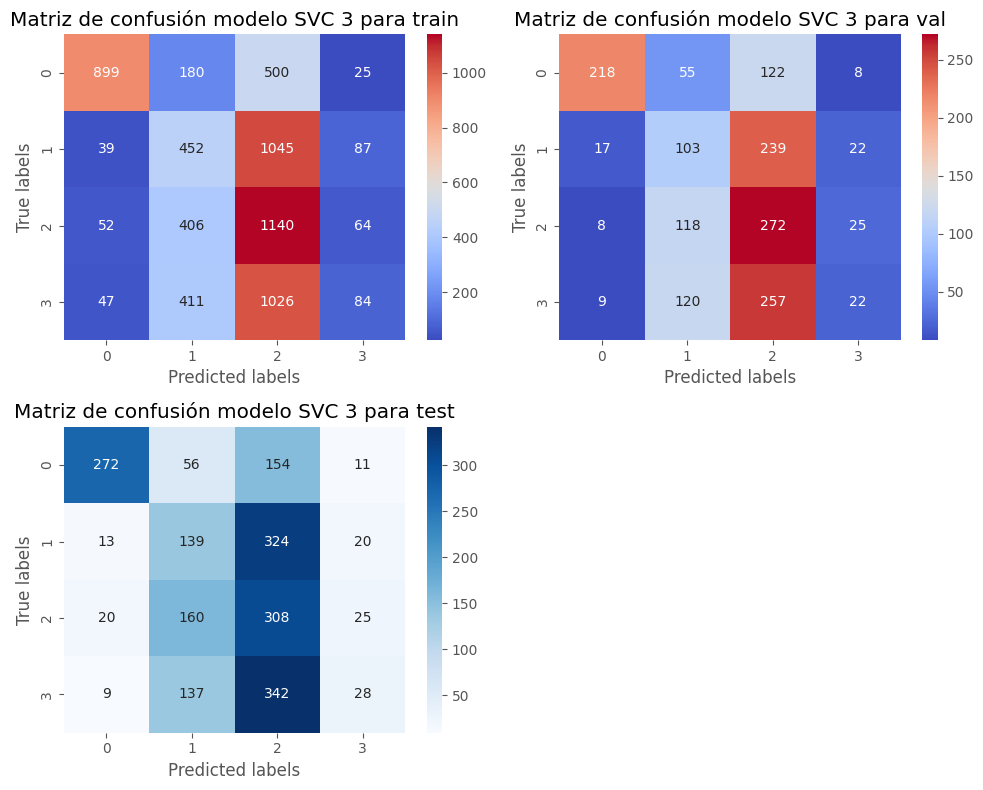

In [28]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model_3,y_val_predict_svc_model_3,y_test_predict_svc_model_3],
    ['Matriz de confusión modelo SVC 3 para train', 'Matriz de confusión modelo SVC 3 para val', 'Matriz de confusión modelo SVC 3 para test']
    )

Parece tener un tope en cuanto a rendimiento, ya que por mas riguroso que se haga no puede quitar su tendencia a predecir la clase 2.

In [29]:
metricas_svc = pd.concat(
[metricas_svc,
 pd_metricas_clasifier(
     {'SVC 3': [
         [10],
         (y_train,y_predict_svc_model_3),
         (y_val, y_val_predict_svc_model_3),
         (y_test,y_test_predict_svc_model_3)
         ]
    }, m_type= 'clasifier', m = 'SVM'
)])

In [30]:
metricas_svc

,Nombre_Modelo,C,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,SVC 1,0.050,0.452050,0.399411,0.399411,0.374743,0.429459,0.382043,0.382043,0.359996,0.436442,0.370168,0.370168,0.352478
0,SVC 2,0.001,0.291856,0.388571,0.388571,0.286200,0.531588,0.392570,0.392570,0.289127,0.285066,0.378593,0.378593,0.277565
0,SVC 3,10.000,0.451288,0.398792,0.398792,0.374628,0.429457,0.380805,0.380805,0.360086,0.435710,0.370168,0.370168,0.353134


Lo comentado anteriormente también se puede ver en su Accuracy para train (Test 1), ya que es similar al del primer modelo con C = 0.05.

Estos rendimientos se pueden deber a que se está trabajando con un kernel lineal, el cual no pareciera ser suficiente a la hora de espaciar las clases.1

# Punto 2: Kernel Gaussiano.

**Toto**

Realizar la predicción del atributo Estación utilizando máquinas de vectores con kernel gaussiano analizando los parámetros costo y gama. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

# Punto 3: Random Forest.

**Juli**

Realizar la predicción del atributo Estación utilizando Random Forest analizando los parámetros cantidad de estimadores y la máxima profundidad de los  rboles. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

In [31]:
model_rf = make_pipeline(StandardScaler(), RandomForestClassifier())
model_rf.fit(X_train,y_train)
y_train_predict_model_rf = model_rf.predict(X_train)
y_val_predict_model_rf = model_rf.predict(X_val)
y_test_predict_model_rf = model_rf.predict(X_test)

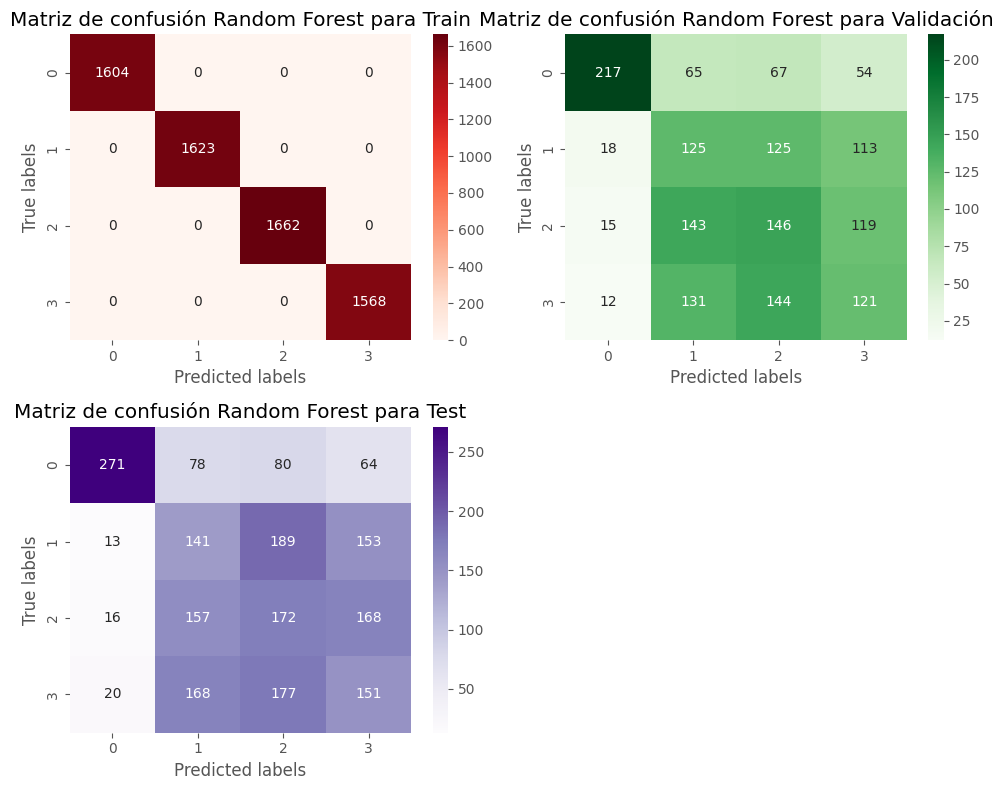

In [32]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_rf, y_val_predict_model_rf, y_test_predict_model_rf],
    ['Matriz de confusión Random Forest para Train', 'Matriz de confusión Random Forest para Validación', 'Matriz de confusión Random Forest para Test']
    )

Podemos ver, que las etiquetas se distribuyen de la siguiente forma para las 3 matrices:
- 0: Invierno (se cuenta por fila 1604, 503, 493 predicciones respectivamente)
- 1: Otonio.
- 2: Primavera.
- 3: Verano.

Podemos ver una clasificación perfecta en la matriz de Train; sin embargo, el modelo parece estar sobreajustando ya que su performance en Validación y Test es significativamente menor. Esto se debe posiblemente a que el parámetro por defecto 'n_estimators', es decir la cantidad de árboles, es 100 lo cual parece ser mucho para este problema. 

In [ ]:
pd_metricas_clasifier(
    {'Random Forest 1':[
     [100, 'gini', None, 2, 1, 'sqr'],
     (y_train, y_train_predict_model_rf),
     (y_val, y_val_predict_model_rf),
     (y_test, y_test_predict_model_rf)
     ]
    },
     m = 'RandomForest',
     cv = True,
     
)

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Random Forest 1,100,gini,None,2,1,sqr,1.0,1.0,1.0,1.0,0.424674,0.37709,0.37709,0.392175,0.413385,0.364222,0.364222,0.380238
